In [1]:
import sys
import os

os.chdir("../")

os.getcwd()

'c:\\Users\\dukuku1\\OneDrive - Louisiana State University\\Documents\\LSU\\Classes\\2nd year\\Spring\\Che 7700\\Project\\ezyzip (1)'

In [2]:
from src.data_preprocess import DataPreprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.metrics import silhouette_score

In [3]:
###############################
### 1. Data Preprocessing  ###
###############################

# Load dataset
# file_path = "data/Load_data_new.csv"
# preprocessor = DataPreprocessing()

# data = preprocessor.load_data(file_path)
###############################
### 1. Data Preprocessing  ###
###############################

# Load dataset
file_path = "data/Load_data_new.csv"  
data = pd.read_csv(file_path)

# Selecting numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Convert 'total_cloud_cover' to numeric
def convert_cloud_cover(value):
    if value == 'no clouds':
        return 0
    elif value == 'Sky obscured by fog and/or other meteorological phenomena.':
        return 10  
    elif isinstance(value, str) and '/' in value:
        parts = value.split('/')
        return float(parts[0]) / float(parts[1].split('–')[0])
    else:
        return np.nan

data['total_cloud_cover[from ten]'] = data['total_cloud_cover[from ten]'].apply(convert_cloud_cover)
data['total_cloud_cover[from ten]'] = data['total_cloud_cover[from ten]'].fillna(data['total_cloud_cover[from ten]'].median())

# Drop non-numeric columns (e.g., 'Time')
data = data.drop(columns=['Time'])

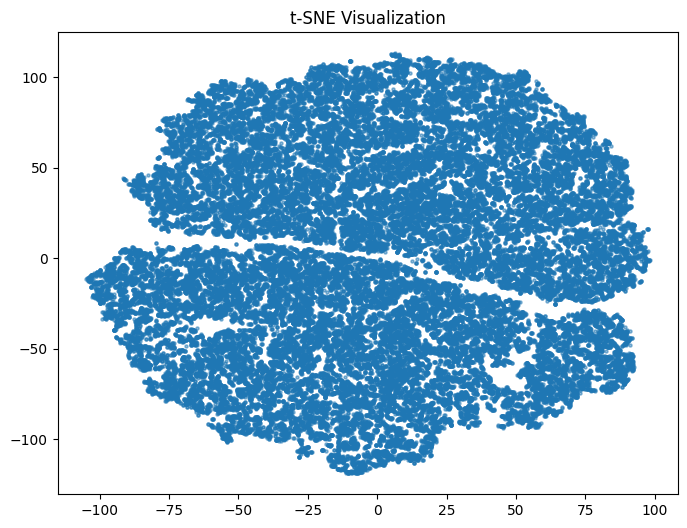

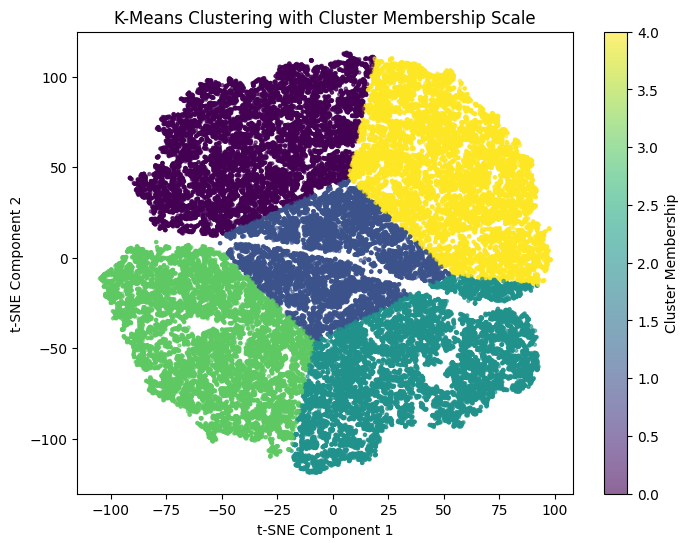

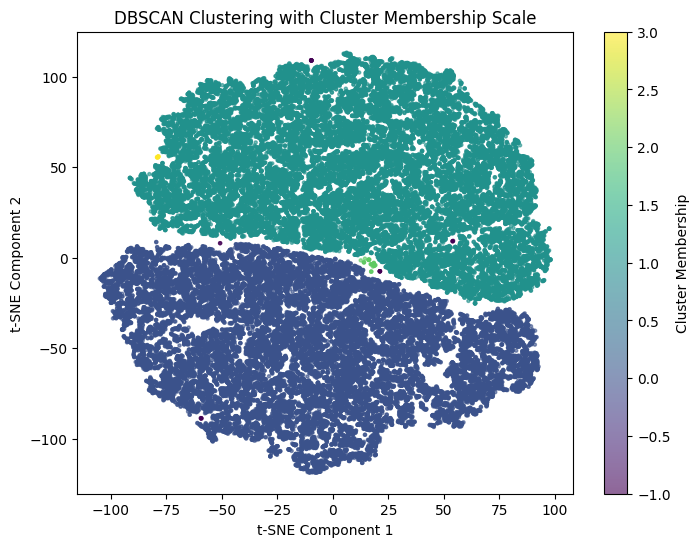

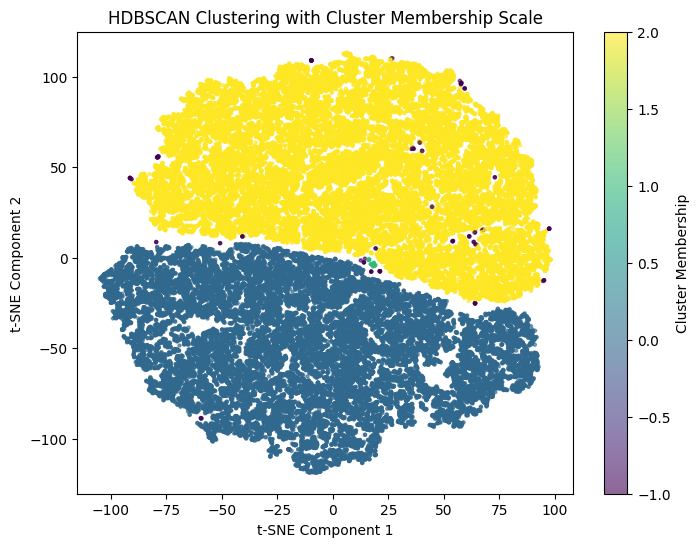

K-Means Silhouette Score: 0.35
DBSCAN Silhouette Score: -0.14
HDBSCAN Silhouette Score: -0.04


In [4]:
# Selecting numeric columns
# numeric_columns = data.select_dtypes(include=[np.number]).columns
# data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())
###############################
### 2. Feature Scaling      ###
###############################
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

#########################################
### 3. Dimensionality Reduction (t-SNE) ##
#########################################
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_data = tsne.fit_transform(scaled_data)

save_path = "plots"
# Visualize t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=5, alpha=0.5)
plt.title('t-SNE Visualization')
plt.savefig(os.path.join(save_path, 't-SNE Visualization.png'))
plt.show()

#########################################
### 4. Clustering (KMeans, DBSCAN, HDBSCAN) ###
#########################################

# K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(tsne_data)

# DBSCAN
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_labels = dbscan.fit_predict(tsne_data)

# HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
hdb_labels = hdb.fit_predict(tsne_data)

# Visualizing Clusters with Membership Scale
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=5, alpha=0.6)
    plt.colorbar(scatter, label='Cluster Membership')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.savefig(os.path.join(save_path, title + ".png"))

    plt.show()

plot_clusters(tsne_data, kmeans_labels, 'K-Means Clustering with Cluster Membership Scale')
plot_clusters(tsne_data, dbscan_labels, 'DBSCAN Clustering with Cluster Membership Scale')
plot_clusters(tsne_data, hdb_labels, 'HDBSCAN Clustering with Cluster Membership Scale')

#########################################
### 5. Evaluation (Silhouette Score) ###
#########################################

def evaluate_clustering(data, labels, method_name):
    if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
        score = silhouette_score(data, labels)
        print(f"{method_name} Silhouette Score: {score:.2f}")
    else:
        print(f"{method_name} did not form sufficient clusters for Silhouette scoring.")

evaluate_clustering(tsne_data, kmeans_labels, 'K-Means')
evaluate_clustering(tsne_data, dbscan_labels, 'DBSCAN')
evaluate_clustering(tsne_data, hdb_labels, 'HDBSCAN')
